# Import Required Libraries

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

# Step 0: Data Acquisition

In this step, we start by downloading and reading the data. The different data tables are then filtered, cleaned and stadardized to get the final confirmed daily infection rate. We finally plot visualizations to understand the trends

## Reading the required CSVs

In [14]:
raw_us_confirmed_cases = pd.read_csv("RAW_us_confirmed_cases.csv")    # Reading confirmed cases CSV
mask_use_by_county = pd.read_csv("mask-use-by-county.csv")            # Reading Voluntary mask survey data
maricopa_mask_mandates_april_2020_aug_2021 = pd.read_csv("U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
                                # Reading masking policy data for Maricopa County (Filtered while Acquisition)

### Data Filtering and Cleaning for Analysis

In [ ]:
raw_maricopa_cases = raw_us_confirmed_cases[(raw_us_confirmed_cases["Province_State"] == "Arizona") & (raw_us_confirmed_cases["Admin2"] == "Maricopa")]
                                # Filtering confirmed cases for Maricopa County

In [89]:
raw_maricopa_cases.columns[0:11]        # Checking for columns to extract date specific data

Index(['Province_State', 'Admin2', 'UID', 'iso2', 'iso3', 'code3', 'FIPS',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key'],
      dtype='object')

In [17]:
# Get the general county information and then FIPS value to filter the dataframes later

maricopa_general_info = raw_maricopa_cases[raw_maricopa_cases.columns[0:11]]

maricopa_FIPS = maricopa_general_info["FIPS"].values[0]

maricopa_FIPS

4013.0

In [15]:
mask_use_by_county.loc[mask_use_by_county['COUNTYFP']==4013]    # Checking values for masking survey data

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
103,4013,0.023,0.025,0.059,0.158,0.734


The masking prevalence values seem to be very high. Around 95% people wearing masks from sometimes to Always. This data is taken from a 2-week survey, hence extrapolation is a problem. We will be using national-level masking policies going ahead.

In [19]:
# Filtering masking survey data to get it for maricopa county
maricopa_mask_use_july2_july14_2020 = mask_use_by_county[mask_use_by_county["COUNTYFP"] == maricopa_FIPS]

In [20]:
# Subsitute N/A with No for masking policies. Assuming people weren't asked to wear the masks 
maricopa_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = maricopa_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")

In [21]:
maricopa_mask_mandates_april_2020_aug_2021.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AZ,Maricopa County,4,13,4/10/2020,2,No,NaN,NaN,NaN
1,AZ,Maricopa County,4,13,4/11/2020,2,No,NaN,NaN,NaN
2,AZ,Maricopa County,4,13,4/12/2020,2,No,NaN,NaN,NaN
3,AZ,Maricopa County,4,13,4/13/2020,2,No,NaN,NaN,NaN
4,AZ,Maricopa County,4,13,4/14/2020,2,No,NaN,NaN,NaN


In [18]:
# Extracting data for maricopa cases by date and creating a separate dataframe

maricopa_cases_by_date =  raw_maricopa_cases[raw_maricopa_cases.columns[11:]]
maricopa_cases_by_date = pd.DataFrame(maricopa_cases_by_date.iloc[0])
maricopa_cases_by_date = maricopa_cases_by_date.reset_index()
maricopa_cases_by_date.columns = ["date", "number_of_cases"]

maricopa_cases_by_date.head()

,date,number_of_cases
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,1


In [22]:
# Calculate the daily infection rate change, by calculating the change of derivative function of infection change
maricopa_cases_by_date["date"] = pd.to_datetime(maricopa_cases_by_date["date"])
maricopa_cases_by_date["case_rate"] = pd.Series(np.gradient(maricopa_cases_by_date["number_of_cases"]), maricopa_cases_by_date["date"], name='case_rate').values

In [23]:
maricopa_cases_by_date.head()

,date,number_of_cases,case_rate
0,2020-01-22,0,0.0
1,2020-01-23,0,0.0
2,2020-01-24,0,0.0
3,2020-01-25,0,0.5
4,2020-01-26,1,0.5


### Intermediate visualization or EDA of dataframe for analysis

Text(0, 0.5, 'Daily Cumulative Cases')

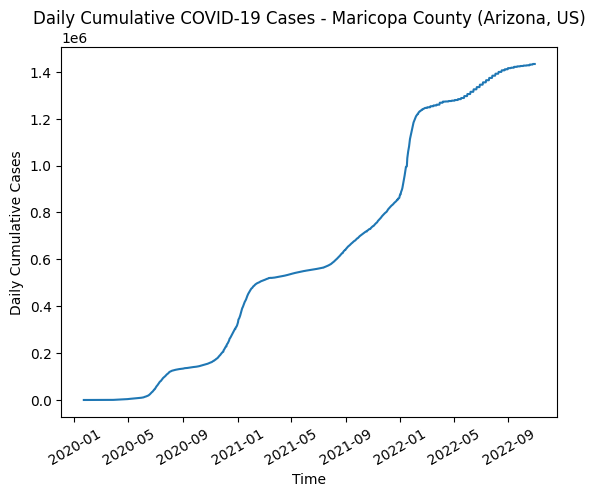

In [92]:
#Plotting the fraph for cumulative cases against time


fig, ax=plt.subplots()
plt.xticks(rotation=30)
ax.plot(maricopa_cases_by_date['date'], maricopa_cases_by_date['number_of_cases'])
plt.title("Daily Cumulative COVID-19 Cases - Maricopa County (Arizona, US)")
plt.xlabel("Time")
plt.ylabel("Daily Cumulative Cases")

Text(0, 0.5, 'Daily Infection Rate Change')

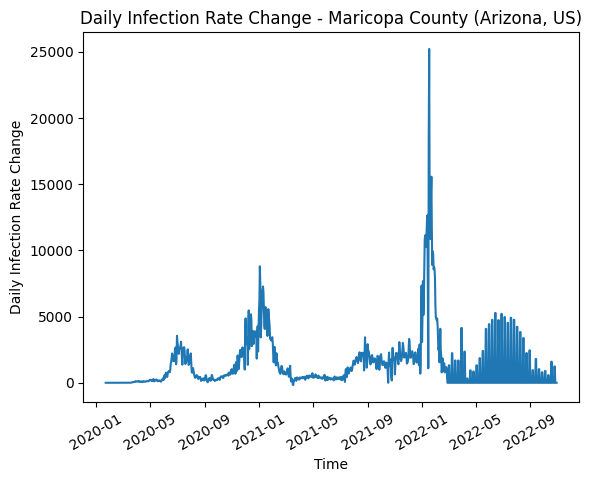

In [93]:
fig, ax=plt.subplots()
plt.xticks(rotation=30)
ax.plot(maricopa_cases_by_date['date'], maricopa_cases_by_date['case_rate'])
plt.title("Daily Infection Rate Change - Maricopa County (Arizona, US)")
plt.xlabel("Time")
plt.ylabel("Daily Infection Rate Change")

### Step 1 : Analyze

In this step, we use the ruptures library to find the change points in the time series. The change in color of graph background shows the change point. We will then evaluate this against the masking policy change

Use of Pelt Search method and Prophet tool Recommendation attributed to Eli Copron and Charles Reinertson respectively(Fellow MSDS Students) 

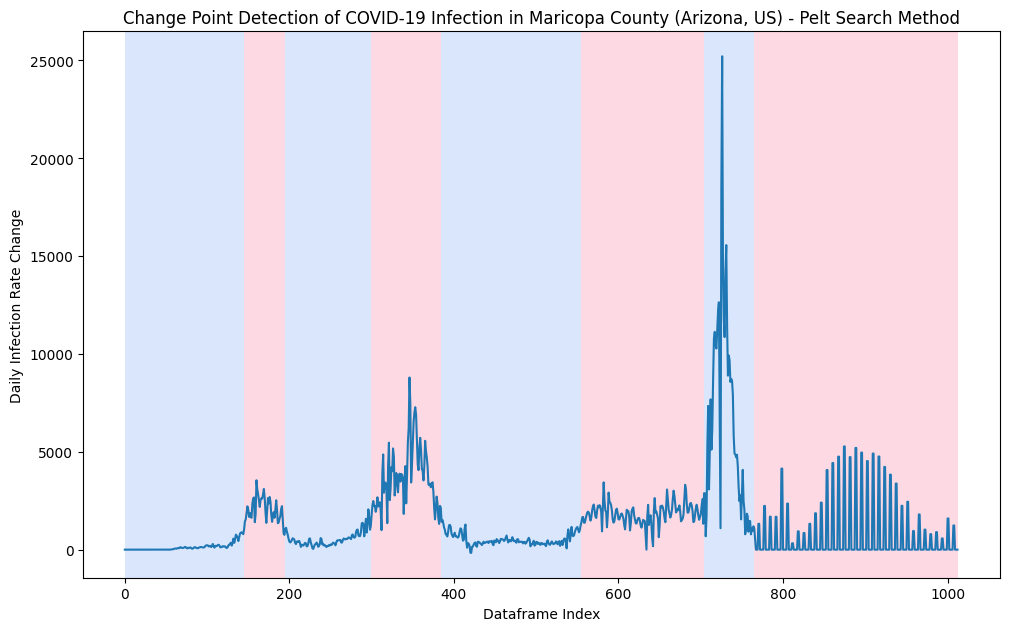

In [95]:
# Using the case rate to run PElt Search method from ruptures to detect change points

casesdata=np.array(maricopa_cases_by_date['case_rate'])

model='rbf'
algo=rpt.Pelt(model=model).fit(casesdata)
result=algo.predict(pen=10)

breaks_rpt=[]
for i in result:
    breaks_rpt.append(maricopa_cases_by_date.index[i-1])

rpt.display(casesdata, result, figsize=(10,6))
plt.title("Change Point Detection of COVID-19 Infection in Maricopa County (Arizona, US) - Pelt Search Method")
plt.xlabel("Dataframe Index")
plt.ylabel("Daily Infection Rate Change")
plt.show()

In [57]:
#Defining the variable names for the above dates

cdc_mask_guidelines_1='2020-04-03'
open_space_cdc_mask_guidelines_removed='2021-01-01'
open_space_cdc_mask_guidelines_set='2021-02-01'
open_space_cdc_mask_guidelines_removed_again='2021-06-10'
full_cdc_mask_guidelines_removed = '2022-02-25'

In [58]:
#Adding a separate column for mask guidelines by CDC in our analysis dataframe

mask_guidelines_list=[]
for i in list(maricopa_cases_by_date.date):
    if str(i) < cdc_mask_guidelines_1:
        mask_guidelines_list.append("No_mask_required")
    elif str(i) < open_space_cdc_mask_guidelines_removed:
        mask_guidelines_list.append("Mask_required_all_places")
    elif str(i) < open_space_cdc_mask_guidelines_set:
        mask_guidelines_list.append("Mask_required_close_spaces")
    elif str(i) < open_space_cdc_mask_guidelines_removed_again:
        mask_guidelines_list.append("Mask_required_all_places")
    elif str(i) < full_cdc_mask_guidelines_removed:
        mask_guidelines_list.append("Mask_required_close_spaces")
    else:
        mask_guidelines_list.append("No_mask_required")
        
maricopa_cases_by_date['Masks_requirement']=mask_guidelines_list

In [60]:
# Fit and predict on the pelt search method for ruptures again 
casesdata=np.array(maricopa_cases_by_date['case_rate'])

model='rbf'
algo=rpt.Pelt(model=model).fit(casesdata)
result=algo.predict(pen=10)

breaks_rpt=[]
for i in result:
    breaks_rpt.append(maricopa_cases_by_date.index[i-1])

# Step 2: Visualize

In this step, we will be plotting the final visualization with the data point color representing the masking policy changes and the blue lines showing change points in the time series data.

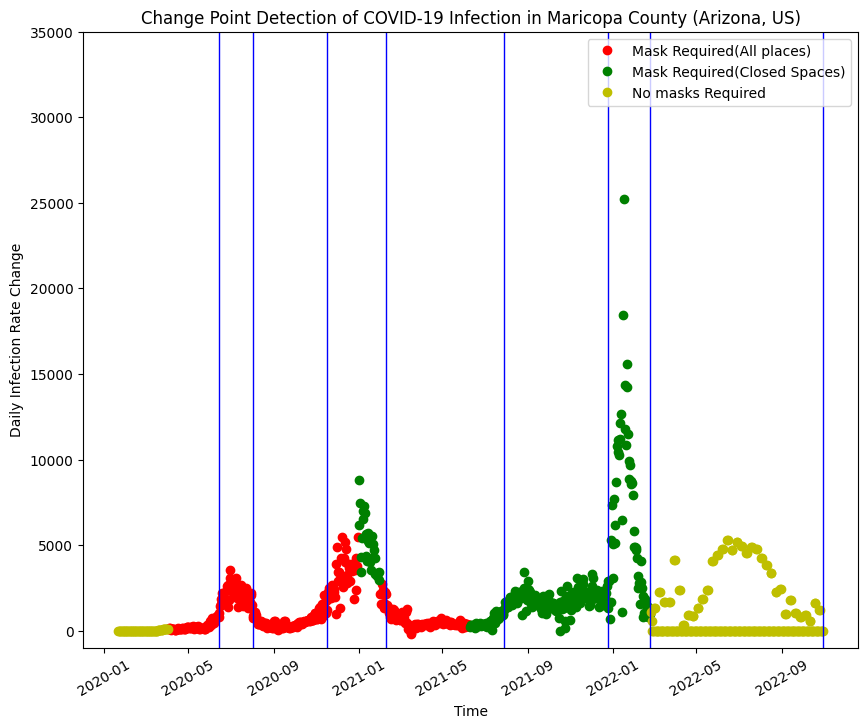

In [86]:
# Filtering data
mask_all_places=maricopa_cases_by_date[maricopa_cases_by_date['Masks_requirement']=='Mask_required_all_places']
mask_close_spaces=maricopa_cases_by_date[maricopa_cases_by_date['Masks_requirement']=='Mask_required_close_spaces']
no_masks_required=maricopa_cases_by_date[maricopa_cases_by_date['Masks_requirement']=='No_mask_required']

# Setting the parameters for the plot
fig = plt.gcf()
plt.xticks(rotation=30)
plt.title("Change Point Detection of COVID-19 Infection in Maricopa County (Arizona, US)")
plt.xlabel("Time")
plt.ylabel("Daily Infection Rate Change")
plt.ylim((-1000,35000))

# Plotting different data points setting mask policy as the color
plt.plot(mask_all_places.date,mask_all_places.case_rate, 'ro', label='Mask Required(All places)')
plt.plot(mask_close_spaces.date,mask_close_spaces.case_rate, 'go', label='Mask Required(Closed Spaces)')
plt.plot(no_masks_required.date,no_masks_required.case_rate, 'yo', label='No masks Required')

leg = plt.legend(loc="upper right")

# Plotting the verticle lines for highlighting changepoints
for x in breaks_rpt:
    plt.axvline(maricopa_cases_by_date.loc[x, 'date'], lw=1, color='blue', label='Change points')
    
fig.set_size_inches(10, 8)
fig.savefig('part1_visualization.png', dpi=100)

1. We see the first change point around 2020-06, which was the first peak of the pandemic, before this even if the masking policies were implemented, people were probably not very serious about it, hence strictly wearing mask policy might not have worked. But then over time masks seemed to work. (Some evidence of masking impacting cases over the longer progression)
2. At the second set of change points, we see that when the cases were declining, the CDC changed the guidelines to less strict policy and the cases continued to decline (No real evidence of mask policy change impact on cases)
3. At the 5th change point (2021-08), we see the mask policy was made less strict and almost a month later the cases started to rise. (Noticeable impact of masks onto the cases)
4. At the next change point, we see that vaccines were available, and people might have reduced wearing masks which led to a rise in cases again and then the next changes would be more of due to vaccines and herd immunity over masks.


Overall, connecting the dots backwards, we could see some impact of masks on infection rates but not always as we ignore the subjective/qualitative aspects of the broader problem (vaccinations, herd immunity, recovery rates, hospitalizations)